In [9]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00


In [10]:
pip install torch

In [11]:
# Step 1: Load and Preprocess the Data
import pandas as pd
import re
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch

# Load the dataset
df = pd.read_csv('Tweets.csv')

# Define functions for preprocessing
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def tokenize(text):
    return text.split()

def join_tokens(tokens):
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(tokenize)
df['clean_text'] = df['tokens'].apply(join_tokens)

# Step 2: Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Load Pre-trained Transformer Model (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Step 4: Tokenize and Encode Text Data
X_train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
X_test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')

# Step 5: Fine-tune the Model
optimizer = AdamW(model.parameters(), lr=1e-5)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_tensor = torch.tensor(y_train.map(label_map).values, dtype=torch.long)

# Define batch size
batch_size = 8

# Train the model (loop over epochs and batches)
for epoch in range(1):  # Adjust as needed
    for i in range(0, len(y_train_tensor), batch_size):
        optimizer.zero_grad()
        outputs = model(input_ids=X_train_encodings['input_ids'][i:i+batch_size],
                        attention_mask=X_train_encodings['attention_mask'][i:i+batch_size],
                        labels=y_train_tensor[i:i+batch_size])
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Step 6: Evaluate the Model
model.eval()
y_test_tensor = torch.tensor(y_test.map(label_map).values, dtype=torch.long)

with torch.no_grad():
    outputs = model(input_ids=X_test_encodings['input_ids'], attention_mask=X_test_encodings['attention_mask'])
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)

accuracy = (predictions == y_test_tensor).sum().item() / len(y_test_tensor)
print(f'Accuracy: {accuracy:.2f}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Accuracy: 0.84


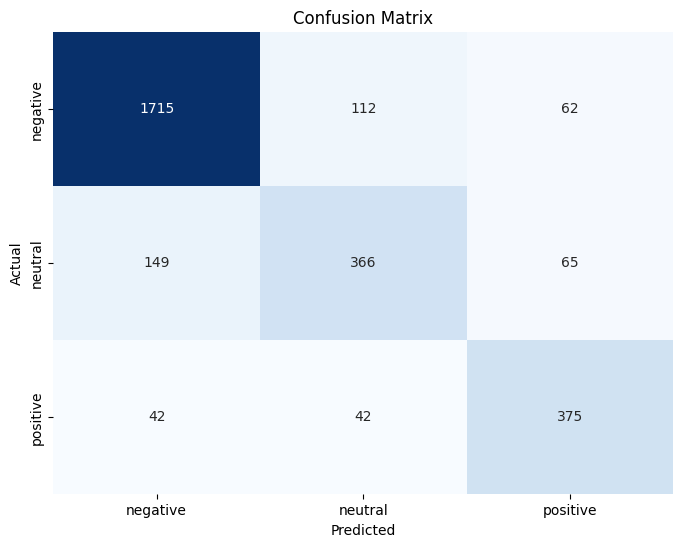

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_tensor, predictions)

# Define class labels
class_names = ['negative', 'neutral', 'positive']

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

